In [1]:
import numpy as np
import scipy as sc
import neo
import quantities as pq
import matplotlib.pyplot as plt
import sys
import os
from copy import copy

In [5]:
sys.path.append('../pipeline/')
from settings import output_path
from utils import AnalogSignal2ImageSequence
output_path = '/home/rgutzen/ProjectsData/wave_analysis_pipeline/LENS/'
data_path = os.path.join(output_path, 'stage04_wavefront_detection', 'optical_flow', 'waves.nix')

with neo.NixIO(data_path) as io:
        block = io.read_block()
    

In [6]:
# block.segments[0].analogsignals[0] = block.segments[0].analogsignals[0].time_slice(0*pq.s, 1*pq.s)
block = AnalogSignal2ImageSequence(block)
vec_frames = block.segments[0].imagesequences[1].as_array()
frames = block.segments[0].imagesequences[0].as_array()

In [5]:
block.segments[0].events[0].array_annotations

{'channels': array([5881, 4694, 4693, ..., 9160, 9148, 9459]),
 'x_coords': array([58, 46, 46, ..., 91, 91, 94]),
 'y_coords': array([81, 94, 93, ..., 60, 48, 59])}

In [16]:
print(np.nanmax(np.abs(np.real(signal))), np.nanmax(np.abs(np.imag(signal))))

2.9393104164403137 3.9121936000237376


/home/rgutzen/anaconda3/envs/wavescalephant_env/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: Mean of empty slice
  if __name__ == '__main__':


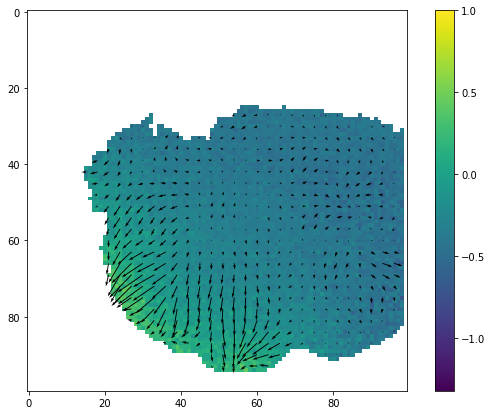

In [7]:
vec_frame = vec_frames[1]
frame = frames[1]
indices = np.where(np.isfinite(frame))
skip_step = 3

plot_frame = vec_frame[indices]
pad_plot_frame = np.pad(plot_frame, (0, skip_step - plot_frame.size%3), 
                        mode='constant', constant_values=np.NaN)
avg_plot_frame = np.nanmean(pad_plot_frame.reshape(-1, 3), axis=1)

fig, ax = plt.subplots(figsize=(10,7))
vmin = np.nanmin(frames)
vmax = np.nanmax(frames)
cmap = plt.get_cmap('viridis')
img = ax.imshow(frame, interpolation='nearest',
                cmap=cmap, vmin=vmin, vmax=vmax)
plt.colorbar(img, ax=ax)
dim_x, dim_y = frame.shape
ax.quiver(np.arange(dim_y)[::skip_step],
          np.arange(dim_x)[::skip_step],
          np.real(vec_frame[::skip_step,::skip_step]),
          -np.imag(vec_frame[::skip_step,::skip_step]))

In [56]:
np.iscomplexobj(vec_frame)

True

In [33]:
from scipy import interpolate

def interpolate_nan_sites(frames, bad_sites=None, angle_flag=False):
    if frames.ndim < 2 or 3 < frames.ndim:
        raise InputError
    elif frames.ndim == 2:
        frames = frames[np.newaxis, :, :]
    else:
        pass

    # create union of bad sites and nan sites
    if bad_sites is None:
        bad_sites = np.array([[],[]])
    nan_sites = np.where(np.bitwise_not(np.isfinite(frames[0])))
    rm_idx = np.array([], dtype=int)
    for x,y in zip(bad_sites[0], bad_sites[1]):
        inx = np.where(x == nan_sites[0])[0]
        iny = np.where(y == nan_sites[1])[0]
        rm_idx = np.append(rm_idx,
                           np.intersect1d(inx, iny, assume_unique=True))
    nan_sites = (np.delete(nan_sites[0], rm_idx),
                 np.delete(nan_sites[1], rm_idx))
    nan_x, nan_y = np.append(nan_sites, bad_sites, axis=1)

    x, y = np.where(np.isfinite(frames[0]))
    nan_x, nan_y = np.where(np.bitwise_not(np.isfinite(frames[0])))

    # interpolate
    for i, frame in enumerate(frames):
        f = interpolate.interp2d(x, y, frame[x,y], kind='cubic')
        znew = f(np.arange(frame.shape[0]),
                 np.arange(frame.shape[1]))
        frames[i][nan_x,nan_y] = znew.T[nan_x,nan_y]
    return frames

In [27]:
f = nsvec_frame[::skip_step,::skip_step]
x = np.arange(vec_frame.shape[0])[::skip_step]
x.shape
f.shape

(34, 34)

In [69]:
import imageio
from pathlib import Path
from matplotlib.pyplot import show
from argparse import ArgumentParser
from scipy.ndimage import convolve as filter2
import numpy as np
from typing import Tuple
#
HSKERN = np.array([[1/12, 1/6, 1/12],
                   [1/6,    0, 1/6],
                   [1/12, 1/6, 1/12]], float)

kernelX = np.array([[-1, 1],
                    [-1, 1]]) * .25  # kernel for computing d/dx

kernelY = np.array([[-1, -1],
                    [1, 1]]) * .25  # kernel for computing d/dy

kernelT = np.ones((2, 2))*.25


def HornSchunck(im1: np.ndarray, im2: np.ndarray, *,
                alpha: float = 0.001, Niter: int = 8,
                verbose: bool = False) -> Tuple[np.ndarray, np.ndarray]:
    """
    Parameters
    ----------
    im1: numpy.ndarray
        image at t=0
    im2: numpy.ndarray
        image at t=1
    alpha: float
        regularization constant
    Niter: int
        number of iteration
    """
    im1 = im1.astype(np.float32)
    im2 = im2.astype(np.float32)

    # set up initial velocities
    uInitial = np.zeros([im1.shape[0], im1.shape[1]])
    vInitial = np.zeros([im1.shape[0], im1.shape[1]])

    # Set initial value for the flow vectors
    U = uInitial
    V = vInitial

    # Estimate derivatives
    [fx, fy, ft] = computeDerivatives(im1, im2)
    
    
    if verbose:
        from .plots import plotderiv
        plotderiv(fx, fy, ft)

#    print(fx[100,100],fy[100,100],ft[100,100])

        # Iteration to reduce error
    for _ in range(Niter):
        # %% Compute local averages of the flow vectors
        uAvg = filter2(U, HSKERN)
        vAvg = filter2(V, HSKERN)
# %% common part of update step
        der = (fx*uAvg + fy*vAvg + ft) / (alpha**2 + fx**2 + fy**2)
# %% iterative step
        U = uAvg - fx * der
        V = vAvg - fy * der

    return U, V


def computeDerivatives(im1: np.ndarray, im2: np.ndarray) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    fx = filter2(im1, kernelX) + filter2(im2, kernelX)
    fy = filter2(im1, kernelY) + filter2(im2, kernelY)
    # ft = im2 - im1
    ft = filter2(im1, kernelT) + filter2(im2, -kernelT)

    return fx, fy, ft

FILTER = 7


def horn_schunck(signal, alpha: float, Niter: int, verbose: bool):
#     flist = getimgfiles(stem, pat)
    nan_channels = np.where(np.bitwise_not(np.isfinite(signal[-1])))
    for i, frame in enumerate(signal[:-1]):
#         fn1 = flist[i]
#         im1 = imageio.imread(fn1, as_gray=True)

#         #       Iold = gaussian_filter(Iold,FILTER)

#         fn2 = flist[i + 1]
#         im2 = imageio.imread(fn2, as_gray=True)
        #        Inew = gaussian_filter(Inew,FILTER)
        frame[nan_channels] = 0
        next_frame = signal[i+1]
        next_frame[nan_channels] = 0      

        U, V = HornSchunck(frame, next_frame, alpha=1.0, Niter=100)
        compareGraphs(U, V, next_frame, fn=i)

    return U, V


def compareGraphs(u, v, Inew, scale: int = 6, quivstep: int = 3, fn: Path = None):
    """
    makes quiver
    """

    fig, ax = plt.subplots()
    ax.imshow(Inew, cmap='gray', origin='lower')
    
    skip = (slice(None, None, skip_step), slice(None, None, skip_step))
    ax.quiver(indices[0][skip],
              indices[1][skip],
              np.real(frame[indices][skip]),
              np.imag(frame[indices][skip]),
              p[skip])
    ax.set(aspect=1, title='Quiver Plot')
    plt.show()
    # plt.scatter(POI[:,0,1],POI[:,0,0])
    for i in range(0, u.shape[0], quivstep):
        for j in range(0, v.shape[1], quivstep):
            ax.arrow(
                j,
                i,
                v[i, j] * scale,
                u[i, j] * scale,
                color='red',
                head_width=0.5,
                head_length=1,
            )

        # plt.arrow(POI[:,0,0],POI[:,0,1],0,-5)
    if fn:
        ax.set_title(fn)

    plt.draw()
    plt.pause(0.01)


# if __name__ == '__main__':
#     p = ArgumentParser(description='Pure Python Horn Schunck Optical Flow')
#     p.add_argument('stem', help='path/stem of files to analyze')
#     p.add_argument('pat', help='glob pattern of files', default='*.bmp')
#     p.add_argument('-p', '--plot', help='show plots', action='store_true')
#     p.add_argument(
#         '-a', '--alpha', help='regularization parameter', type=float, default=0.001
#     )
#     p.add_argument('-N', help='number of iterations', type=int, default=8)
#     p = p.parse_args()

In [3]:
import numpy as np
a = 1+1j
type(a)

complex

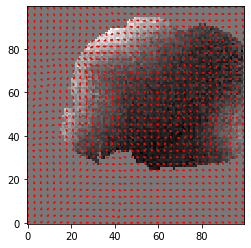

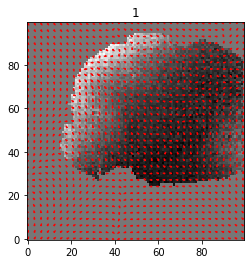

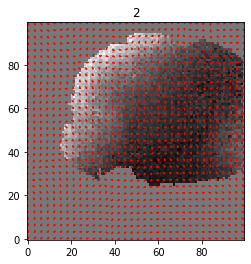

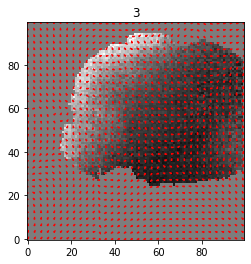

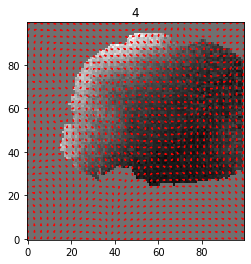

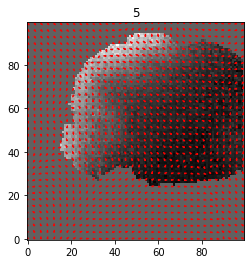

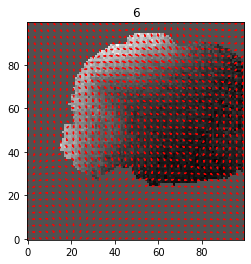

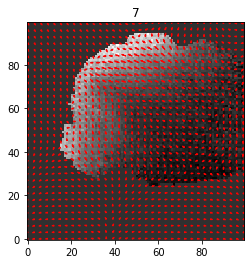

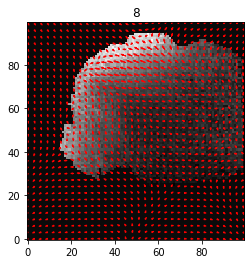

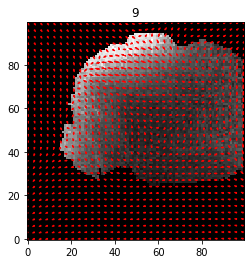

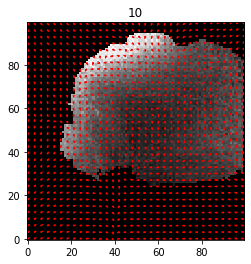

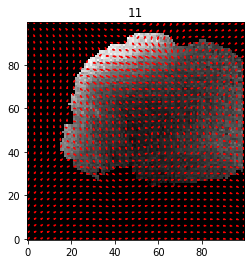

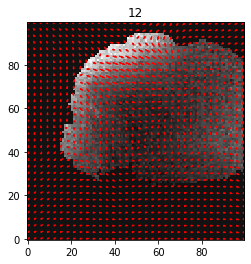

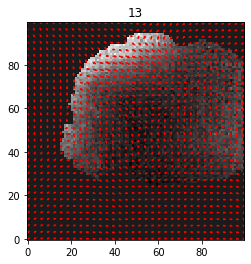

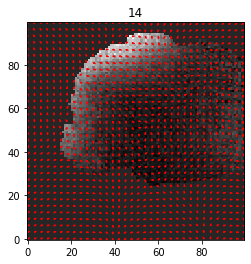

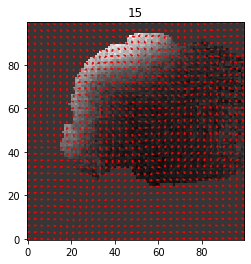

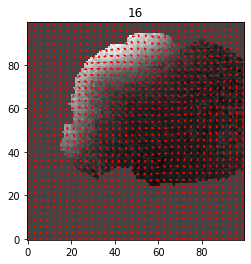

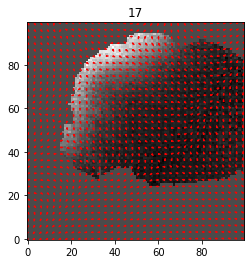

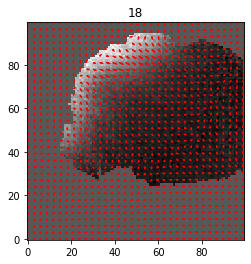

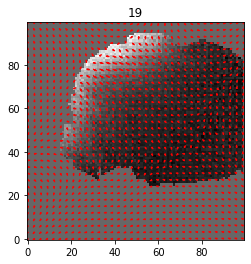

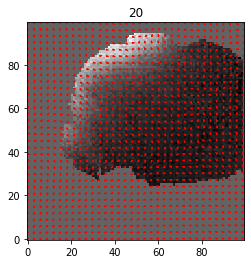

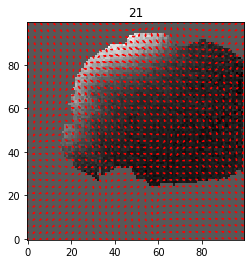

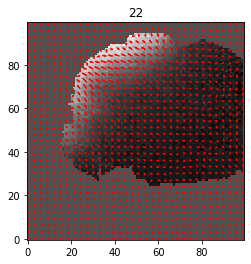

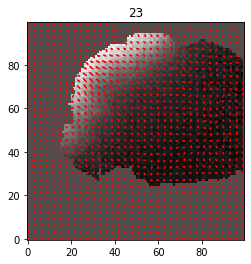

In [70]:
U, V = horn_schunck(signal, alpha=0.1, Niter=100, verbose=True)

show()
# print(U.shape, V.shape)

In [71]:
U

array([[ 9.26985289e-10,  1.05284557e-09,  1.32031242e-09, ...,
         8.47616939e-07,  8.39847843e-07,  8.35849854e-07],
       [ 1.22865660e-09,  1.38926410e-09,  1.72949612e-09, ...,
         1.05665562e-06,  1.04763522e-06,  1.04298503e-06],
       [ 1.91431977e-09,  2.15270071e-09,  2.65549271e-09, ...,
         1.51388603e-06,  1.50228826e-06,  1.49629162e-06],
       ...,
       [-8.05966083e-06, -9.38921135e-06, -1.21873346e-05, ...,
         8.93495238e-05,  8.93846546e-05,  8.93128316e-05],
       [-6.66804447e-06, -7.77996777e-06, -1.01219025e-05, ...,
         8.29158988e-05,  8.32490774e-05,  8.33396268e-05],
       [-5.99268005e-06, -6.99860663e-06, -9.11830052e-06, ...,
         7.95627347e-05,  8.00322243e-05,  8.01975729e-05]])